In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# this will calculate the angular 
# and energy resolution histograms
# %run ../../core/resolution.py
#--renew_calc
# %run ../../core/prepare_histograms.py
## -> only run this if you need to update the histograms

# Import

In [15]:
import pickle
from os.path import join
import numpy as np
import seaborn as sns
from itertools import product
import settings as st

from settings import LOCALPATH, plt, E_MAX, E_MIN
from resolution import comb, g_norm, double_erf


# Load resolution baseline

In [4]:
with open(join(LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    eres_up_mh = pickle.load(f)


In [44]:
with open(join(LOCALPATH, "GP_Eres_mephistograms.pckl"), "rb") as f:
    eres_mh = pickle.load(f)

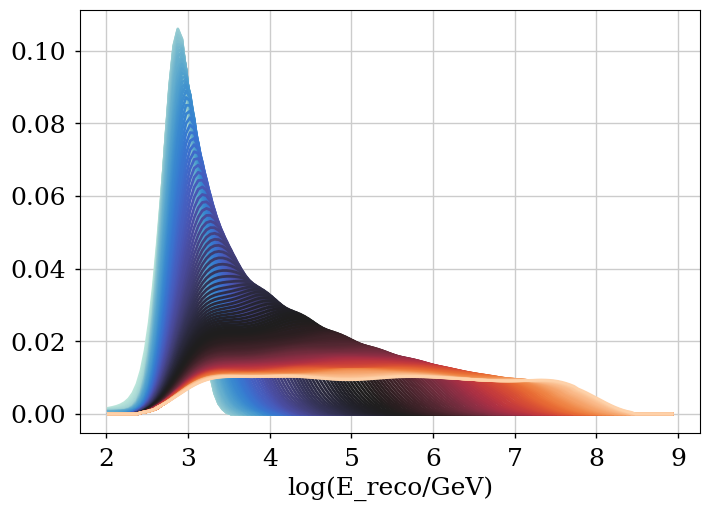

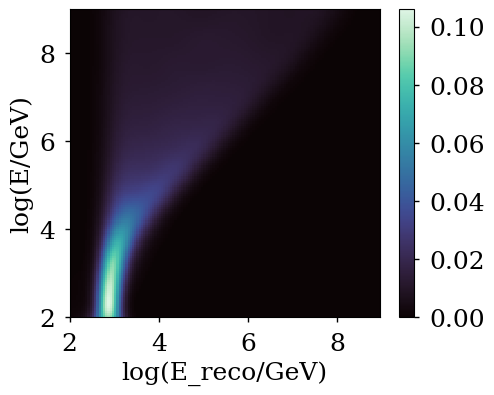

In [5]:
sns.set_palette("icefire", n_colors=eres_up_mh.shape[1] + 1)
_ = plt.plot(eres_up_mh.bin_mids[1], eres_up_mh.histo.T)
plt.xlabel(eres_up_mh.axis_names[1])
eres_up_mh.T().plot()

# crosscheck with raw original resolution

In [7]:
from resolution import read_smearing_matrix, get_baseline_eres

In [8]:
public_data_df = read_smearing_matrix()
log_sm_emids = (public_data_df["logE_nu_min"] + public_data_df["logE_nu_max"]) / 2.0
log_sm_ereco_mids = (public_data_df["logE_reco_min"] + public_data_df["logE_reco_max"]) / 2.0
fractional_event_counts = public_data_df["Fractional_Counts"]
dec_sm_min, dec_sm_max = public_data_df["Dec_nu_min"], public_data_df["Dec_nu_max"]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0

# down-going (=South): -90 -> -10 deg
# horizontal: -10 -> 10 deg
# up-going (=North): 10 -> 90 deg

In [9]:
ebins = np.sort(
    np.unique(
        np.concatenate([public_data_df["logE_nu_min"], public_data_df["logE_nu_max"]])
    )
)
erecobins = np.sort(
    np.unique(
        np.concatenate([public_data_df["logE_reco_min"], public_data_df["logE_reco_max"]])
    )
)
erecobins = np.linspace(np.min(erecobins), np.max(erecobins), num=len(ebins)+1)


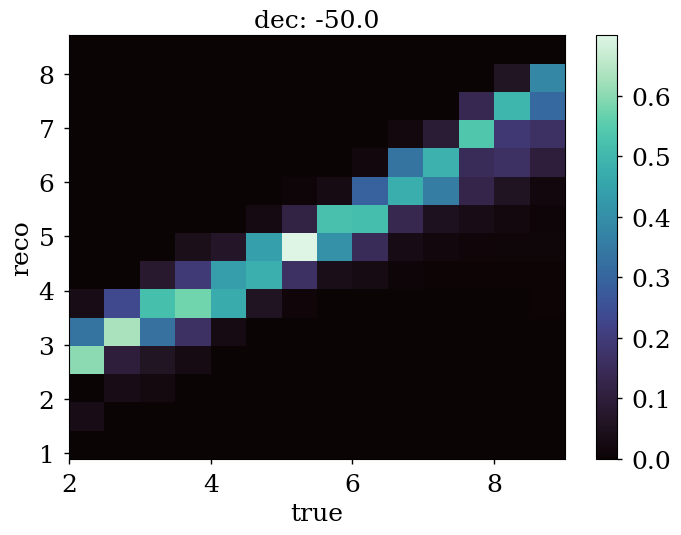

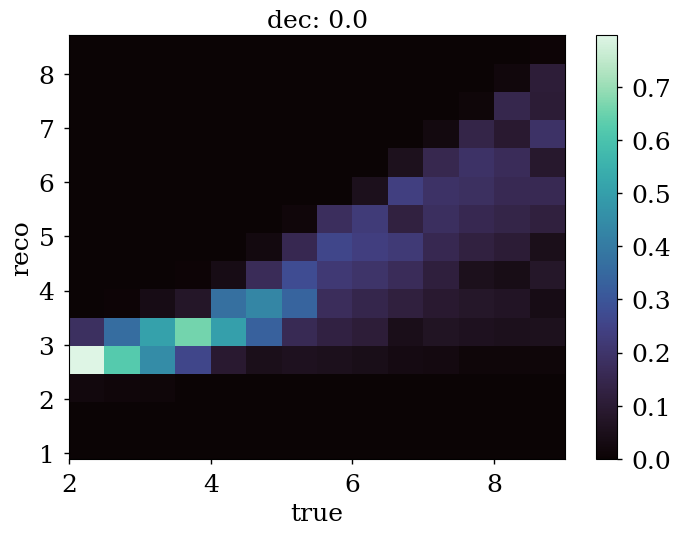

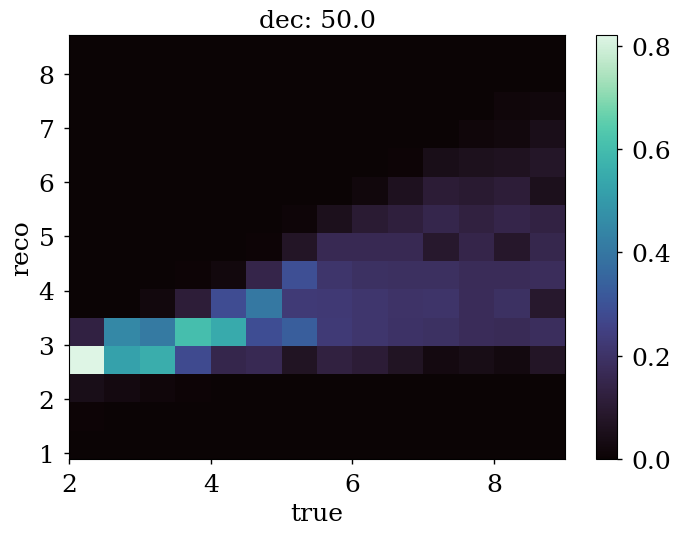

In [20]:
hists = {}
# loop over declination bins
for dd in np.unique(dec_sm_mids):
    dec_mask = dec_sm_mids == dd
    # energy resolution per declination bin
    h, xed, yed = np.histogram2d(
        log_sm_emids[dec_mask],
        log_sm_ereco_mids[dec_mask],
        weights=fractional_event_counts[dec_mask],
        bins=(ebins, erecobins),
    )
    # normalize per bin in true energy
    h = h.T / np.sum(h, axis=1)
    hists[f"dec-{dd}"] = h
    plt.figure()
    plt.title(f"dec: {dd}")
    plt.pcolormesh(xed, yed, h)
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

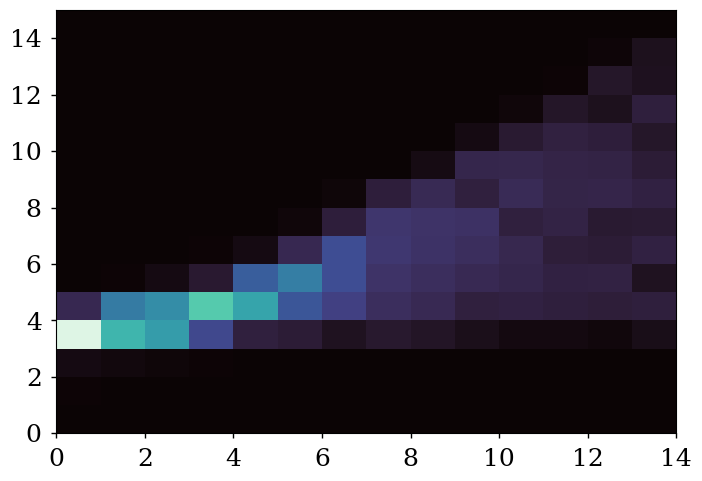

In [21]:
plt.pcolormesh(hists['dec-0.0'] + hists['dec-50.0'])

## GP predictions

In [12]:
_, predictions = get_baseline_eres(renew_calc=True, return_predictions=True)

In [13]:
predictions

{'dec--50.0': GaussianProcessRegressor(alpha=0.0003,
                          kernel=1**2 + Matern(length_scale=1, nu=2.5),
                          n_restarts_optimizer=7),
 'dec-0.0': GaussianProcessRegressor(alpha=2e-05,
                          kernel=1**2 + Matern(length_scale=1, nu=2.5),
                          n_restarts_optimizer=7),
 'dec-50.0': GaussianProcessRegressor(alpha=2e-05,
                          kernel=1**2 + Matern(length_scale=1, nu=2.5),
                          n_restarts_optimizer=7)}

In [16]:
# Input space
logemids = st.get_mids(ebins)
logerecomids = st.get_mids(erecobins)
x1x2 = np.array(list(product(st.logE_mids, st.logE_reco_mids)))
eres_pred, MSE = predictions['dec-0.0'].predict(x1x2, return_std=True)
eres_mesh = np.reshape(
    eres_pred, (len(st.logE_mids), len(st.logE_reco_mids))
)
eres_mesh[eres_mesh <= 3e-2] = 0

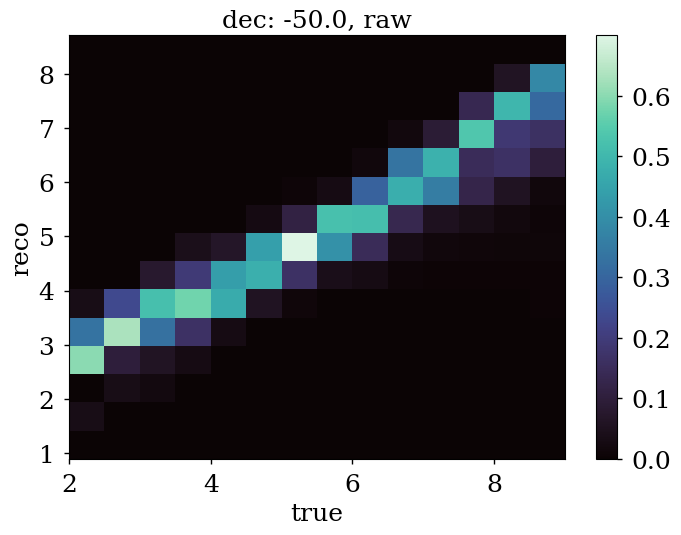

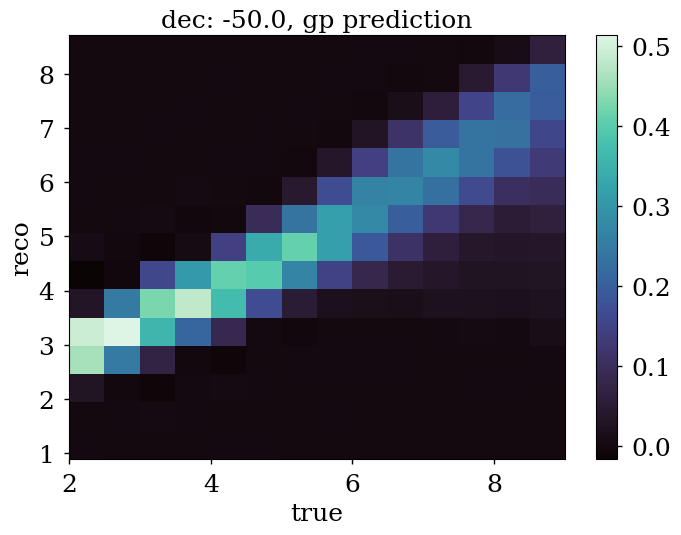

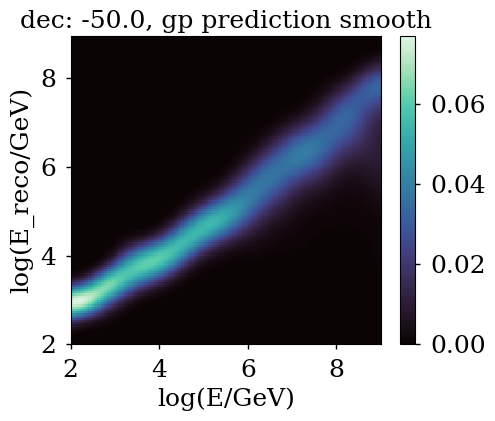

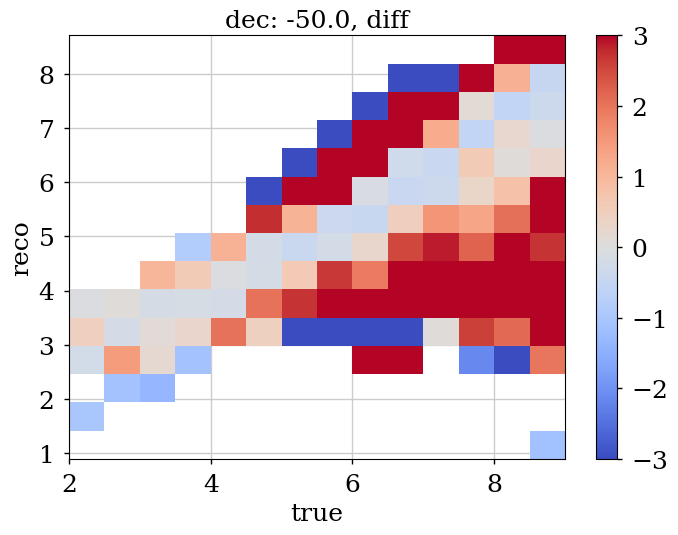

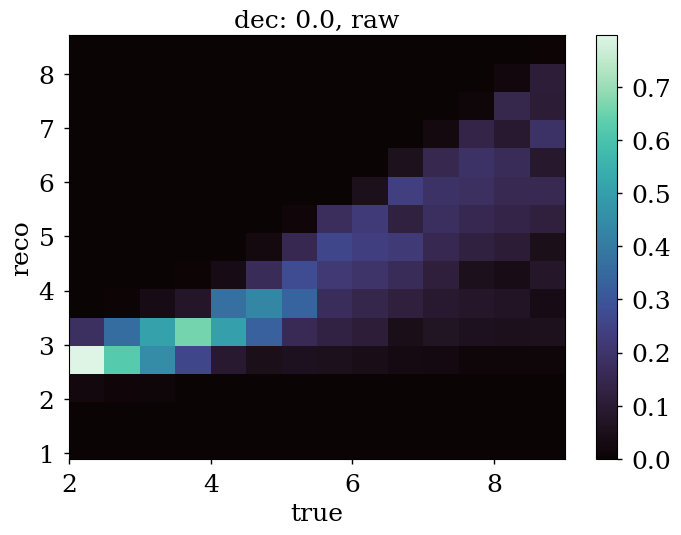

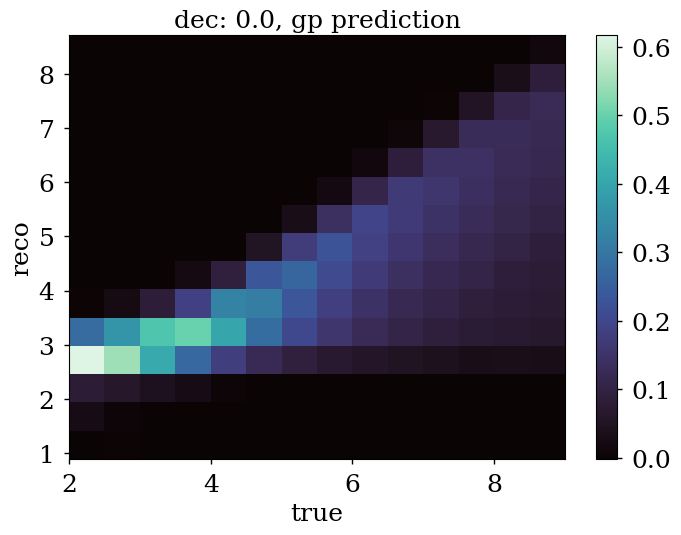

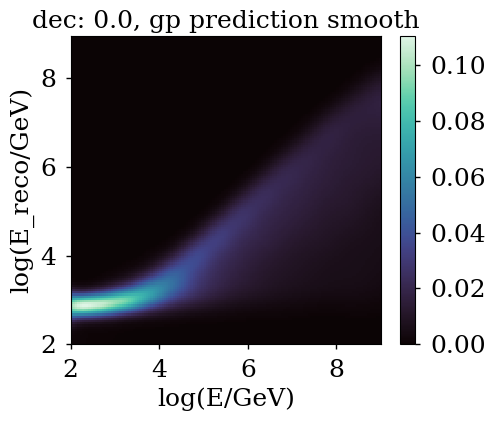

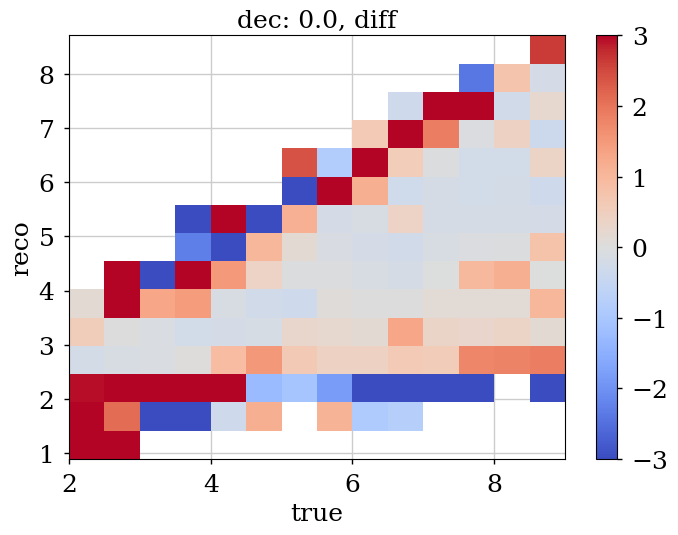

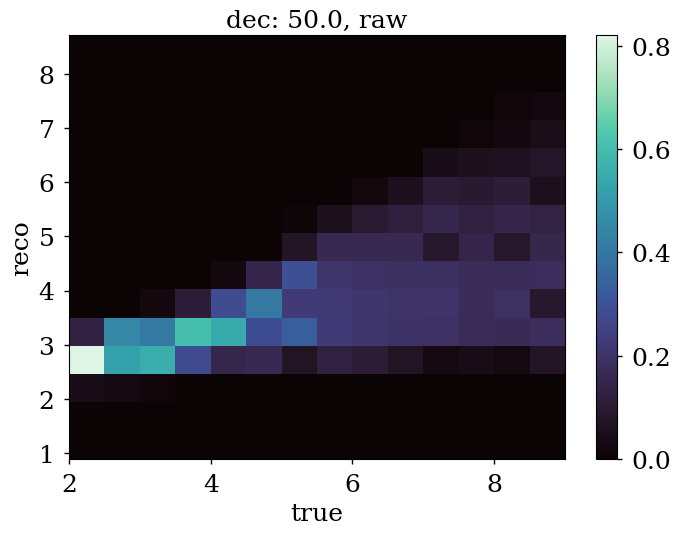

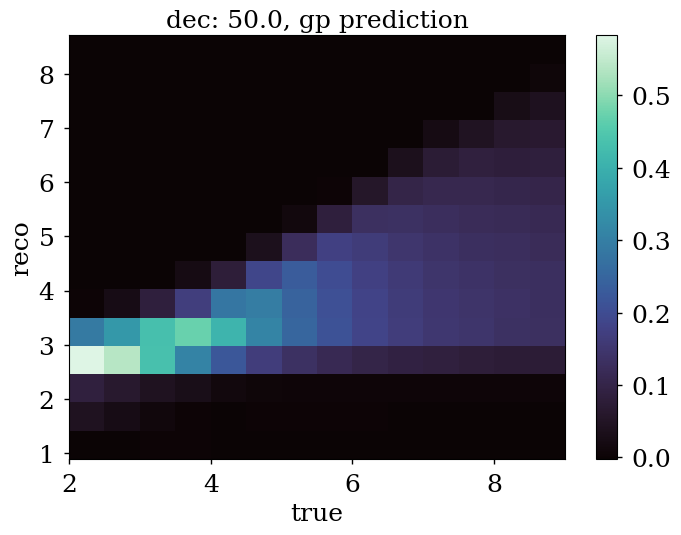

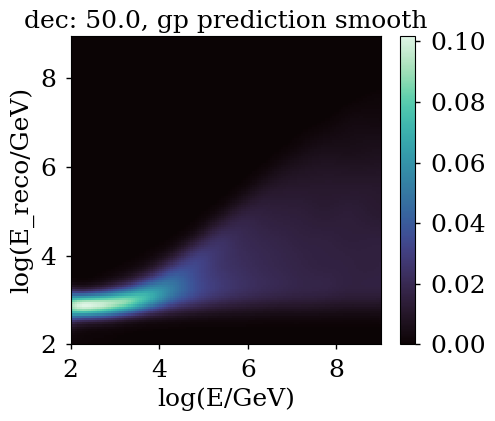

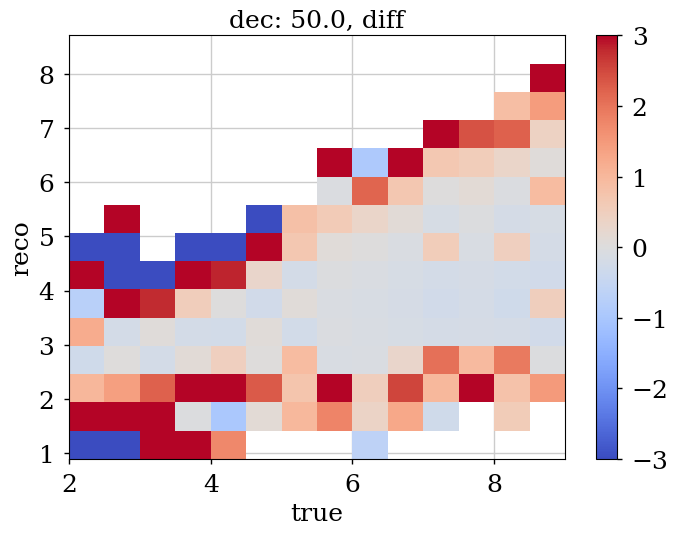

In [47]:
# predict with original binning for comparison
logemids = st.get_mids(ebins)
logerecomids = st.get_mids(erecobins)
for dd in np.unique(dec_sm_mids):
    # hists[f"dec-{dd}"]

    x1x2 = np.array(list(product(logemids, logerecomids)))
    eres_pred, MSE = predictions[f"dec-{dd}"].predict(x1x2, return_std=True)
    eres_mesh = np.reshape(eres_pred, (len(logemids), len(logerecomids)))
    #eres_mesh[eres_mesh <= 3e-2] = 0
    eres_mesh /= eres_mesh.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.title(f"dec: {dd}, raw")
    plt.pcolormesh(ebins, erecobins, hists[f"dec-{dd}"])
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

    plt.figure()
    plt.title(f"dec: {dd}, gp prediction")
    plt.pcolormesh(ebins, erecobins, eres_mesh.T)
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

    eres_mh[f"dec-{dd}"].plot()
    plt.gca().set_title(f"dec: {dd}, gp prediction smooth")

    plt.figure()
    plt.title(f"dec: {dd}, diff")
    plt.pcolormesh(
        ebins,
        erecobins,
        (eres_mesh.T - hists[f"dec-{dd}"]) / hists[f"dec-{dd}"],
        vmin=-3,
        vmax=3,
        cmap="coolwarm",
    )
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

## kde approximations

In [33]:
from resolution import get_baseline_energy_res_kde

In [34]:
all_grids, rs_logE_bins, rs_logE_reco_bins, all_kdes = get_baseline_energy_res_kde(
    return_kde=True, renew_calc=True
)

calculating grids for energy KDE...


In [35]:
all_kdes

{'dec--50.0': <scipy.stats._kde.gaussian_kde at 0x7f2aced850d0>,
 'dec-0.0': <scipy.stats._kde.gaussian_kde at 0x7f2ace819990>,
 'dec-50.0': <scipy.stats._kde.gaussian_kde at 0x7f2acf7834d0>}

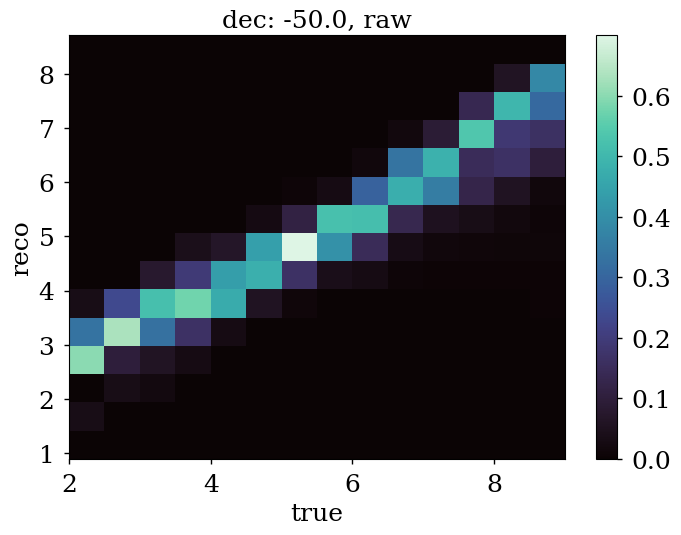

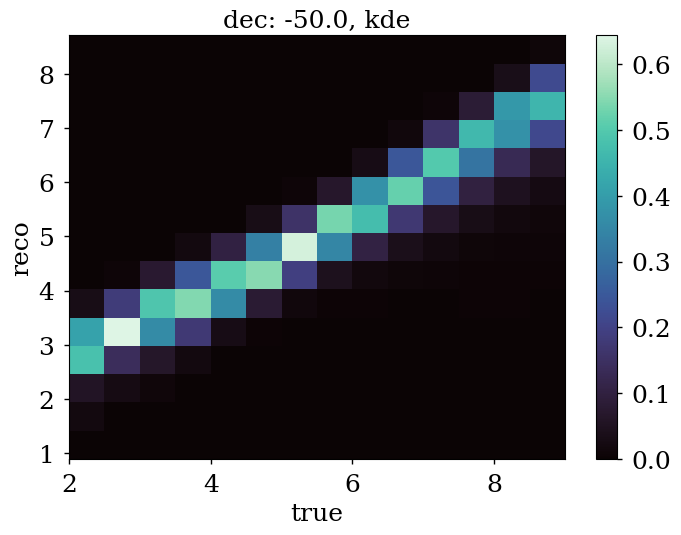

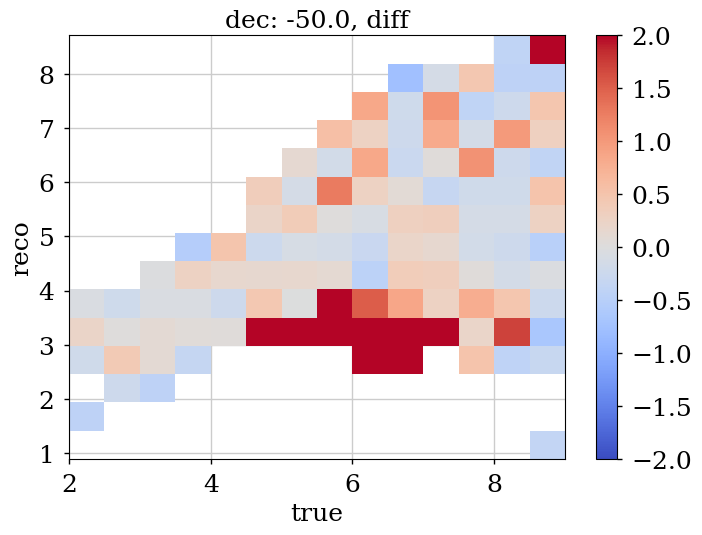

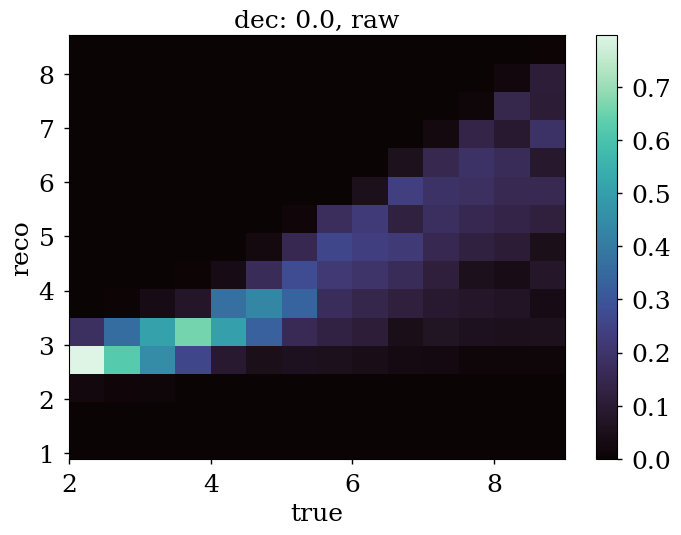

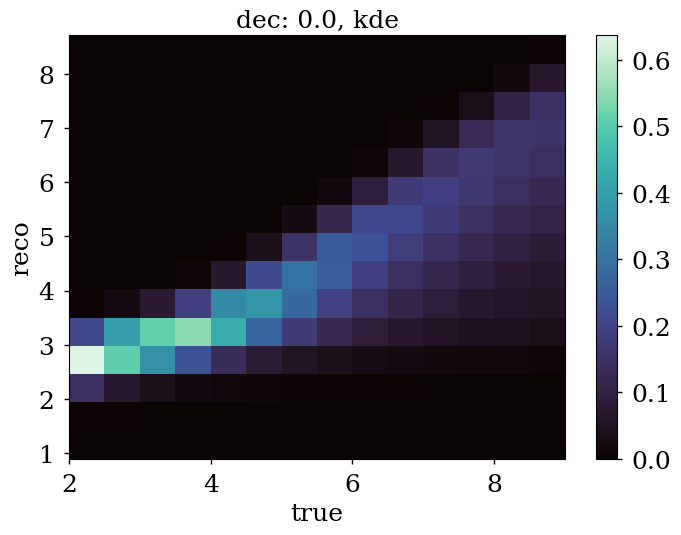

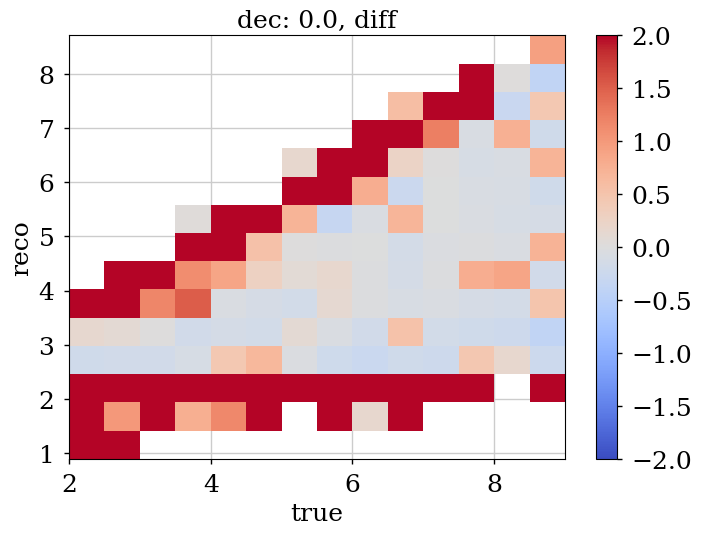

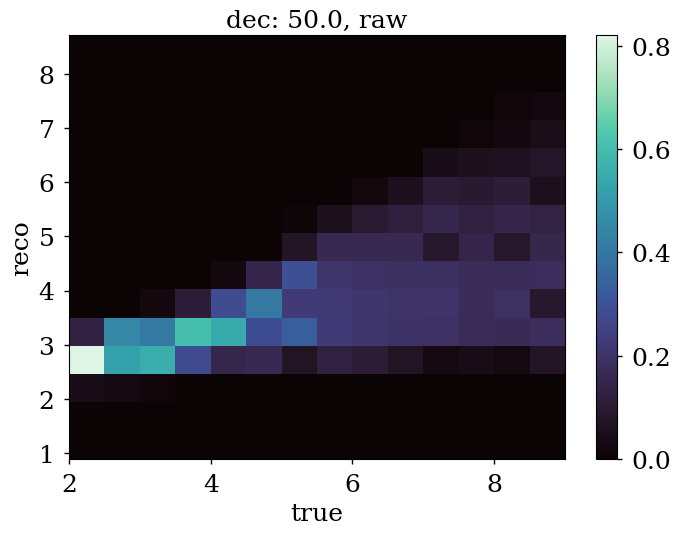

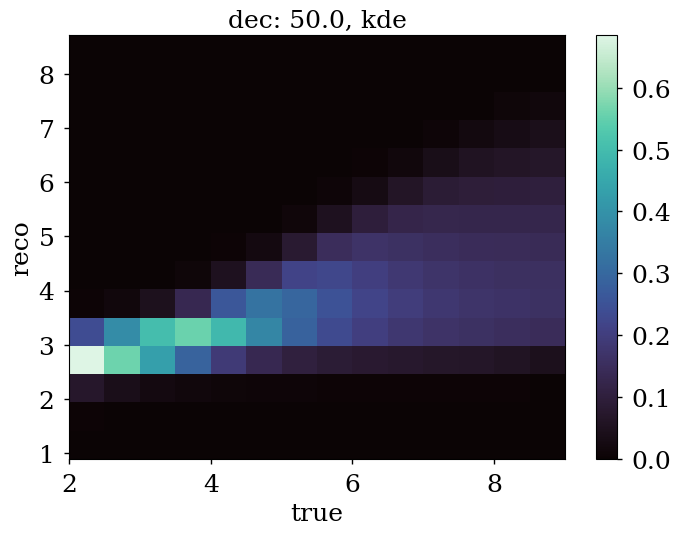

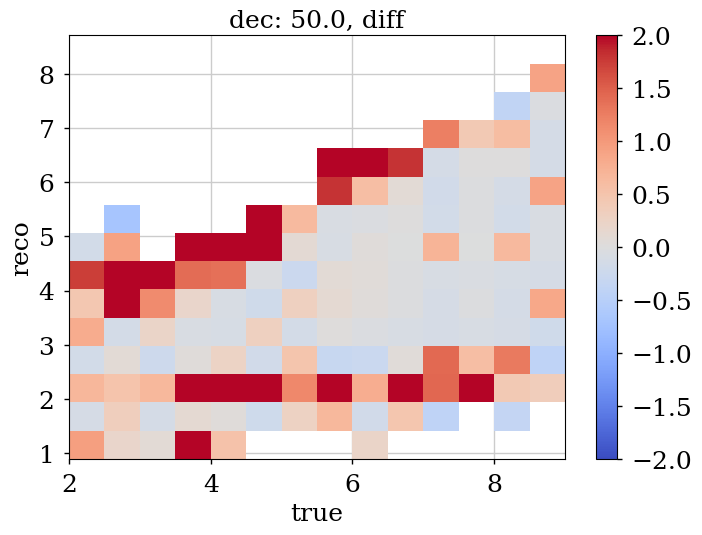

In [40]:
# predict with original binning for comparison
logemids = st.get_mids(ebins)
logerecomids = st.get_mids(erecobins)
for dd in np.unique(dec_sm_mids):
    # hists[f"dec-{dd}"]

    ee, rr = np.meshgrid(logemids, logerecomids)
    eres_mesh = all_kdes[f"dec-{dd}"]([ee.flatten(), rr.flatten()]).reshape(
        len(logerecomids), len(logemids)
    )
    eres_mesh /= eres_mesh.sum(axis=0)

    plt.figure()
    plt.title(f"dec: {dd}, raw")
    plt.pcolormesh(ebins, erecobins, hists[f"dec-{dd}"])
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

    plt.figure()
    plt.title(f"dec: {dd}, kde")
    plt.pcolormesh(ebins, erecobins, eres_mesh)
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

    plt.figure()
    plt.title(f"dec: {dd}, diff")
    plt.pcolormesh(
        ebins,
        erecobins,
        (eres_mesh - hists[f"dec-{dd}"]) / hists[f"dec-{dd}"],
        vmin=-2,
        vmax=2,
        cmap="coolwarm"
    )
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

# Parametrizations

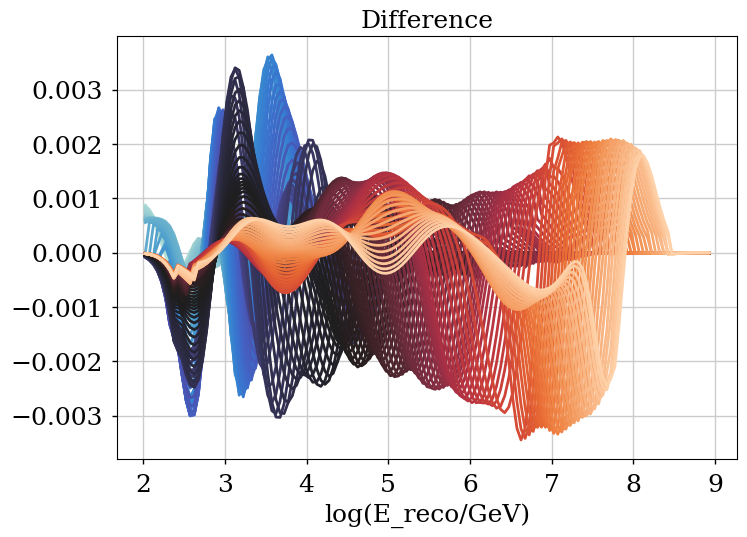

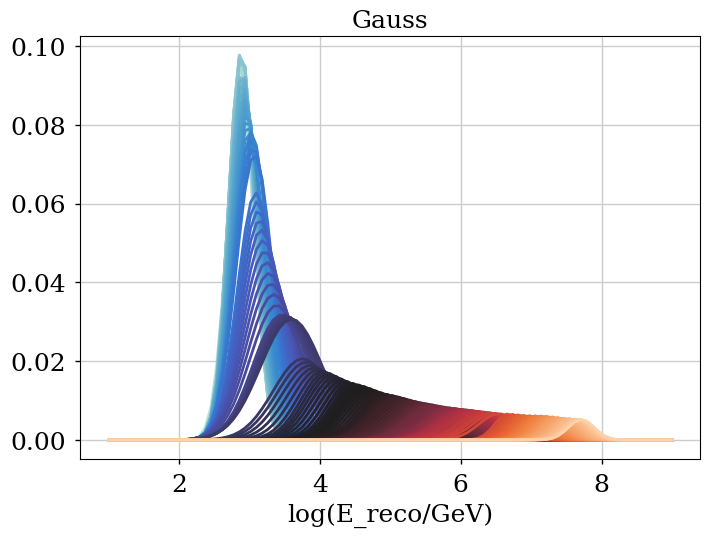

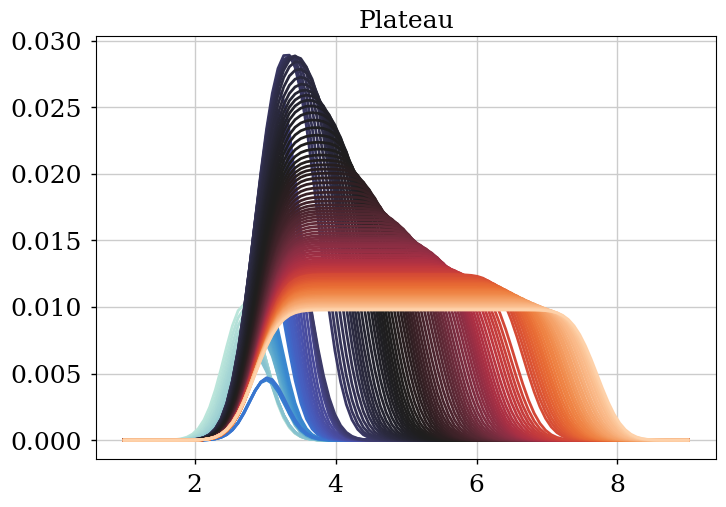

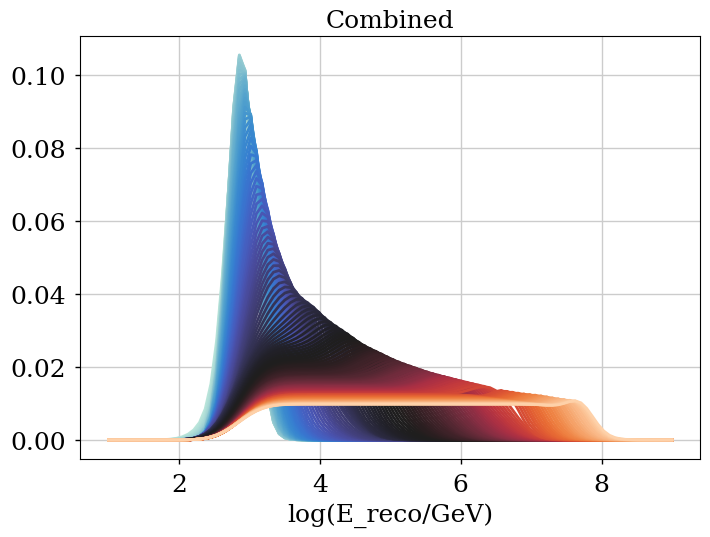

In [6]:
fit_params = np.load(join(LOCALPATH, "Eres_fits_GP.npy"))
xvals = np.linspace(1, 9, num=100)
for ii, et in enumerate(eres_up_mh.bin_mids[0]):
    cur_params = list(fit_params[ii])
    plt.figure(-1)
    plt.title("Difference")
    p = plt.plot(
        eres_up_mh.bin_mids[1],
        eres_up_mh.histo[ii] - comb(eres_up_mh.bin_mids[1], *cur_params),
    )
    plt.xlabel(eres_up_mh.axis_names[1])

    plt.figure(1)
    plt.title("Gauss")
    plt.plot(
        xvals,
        g_norm(xvals, *cur_params[-3:]),
        color=p[0].get_color(),
        lw=2,
    )
    plt.xlabel(eres_up_mh.axis_names[1])
        
    plt.figure(3)
    plt.title("Plateau")
    plt.plot(
        xvals,
        double_erf(xvals, *[cur_params[i] for i in (0, 2, 1)]),
        color=p[0].get_color(),
        lw=2,
    )
    plt.figure(2)
    plt.title("Combined")
    plt.plot(
        xvals,
        comb(xvals, *cur_params),
        color=p[0].get_color(),
        lw=2,
        zorder=10,
    )
    plt.xlabel(eres_up_mh.axis_names[1])



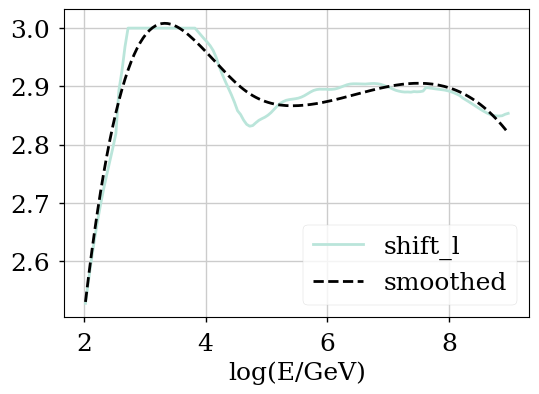

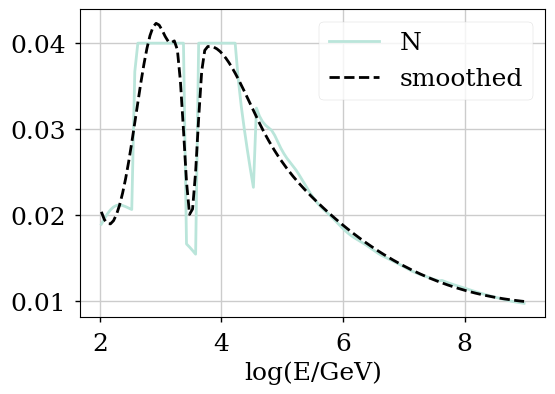

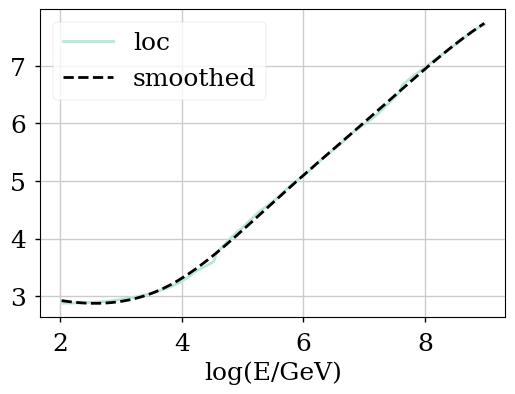

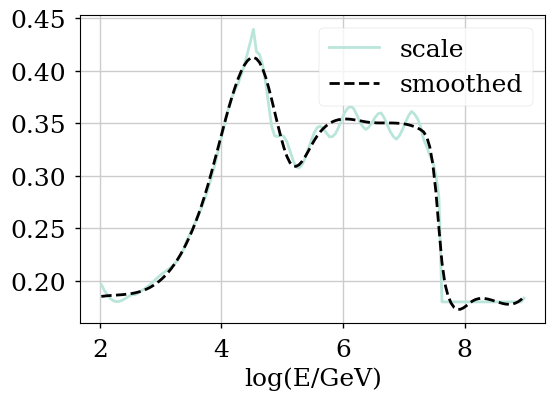

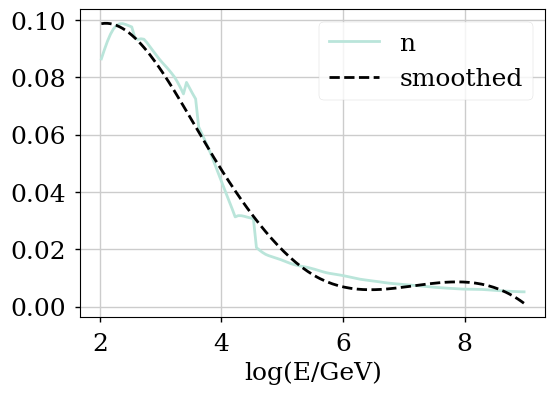

In [7]:
smoothed_fit_params = np.load(join(LOCALPATH, "Eres_fits_smoothed_GP.npy"))

for n in fit_params.dtype.names:
    plt.figure(figsize=(6, 4))
    p = plt.plot(eres_up_mh.bin_mids[0], fit_params[n], label=n)
    p = plt.plot(
        eres_up_mh.bin_mids[0],
        smoothed_fit_params[n],
        label="smoothed",
        color="k",
        ls="--",
    )
    plt.xlabel(eres_up_mh.axis_names[0])
    plt.legend()


# Artificial smearing matrices

## Best reproduction

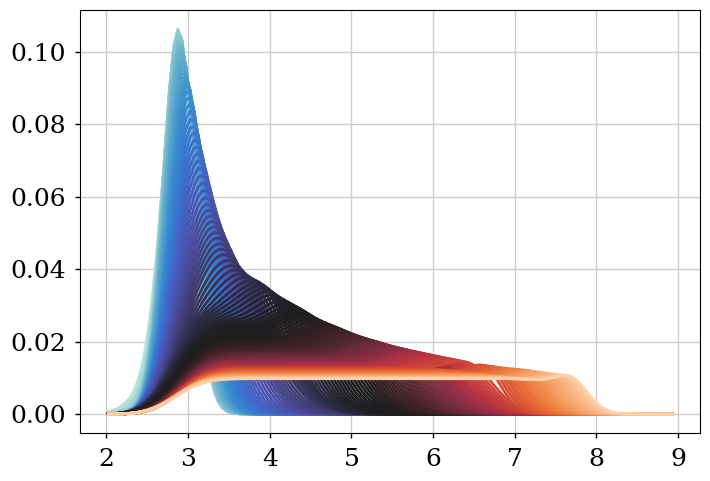

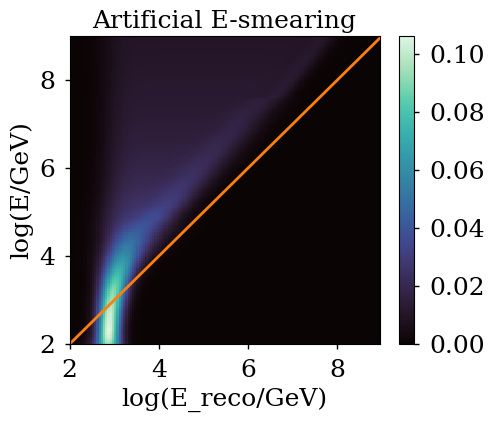

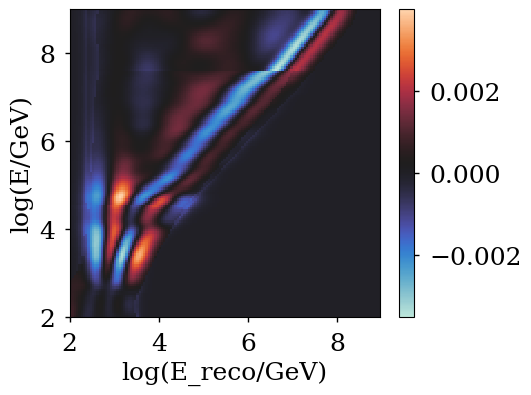

In [8]:
with open(join(LOCALPATH, "artificial_energy_smearing_GP_up.pckl"), "rb") as f:
    artificial_2D = pickle.load(f)

_ = plt.plot(artificial_2D.bin_mids[1], artificial_2D.histo.T)

artificial_2D.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")

plt.title("Artificial E-smearing")

(eres_up_mh - artificial_2D).T().plot(cmap="icefire")


## Smoothed reproduction


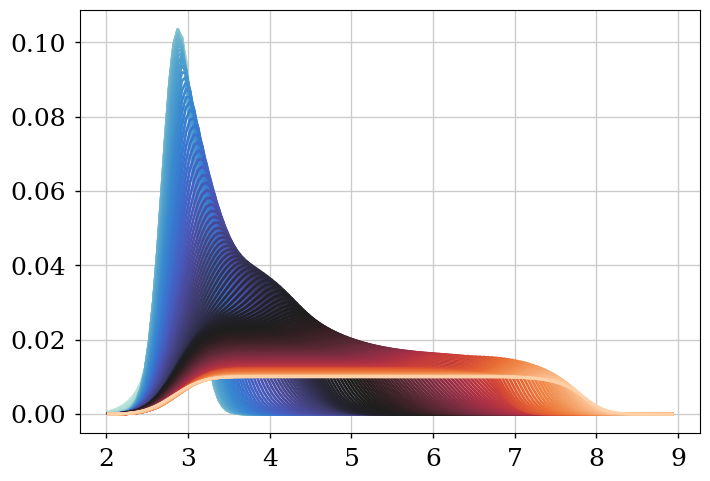

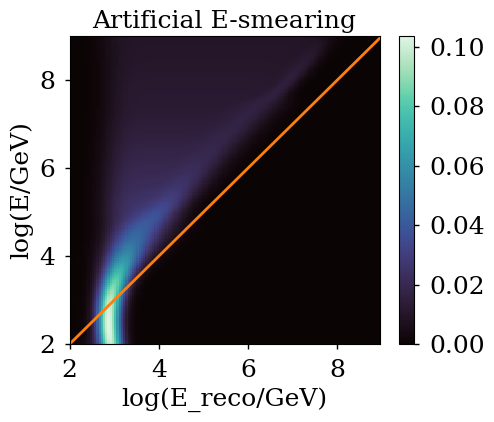

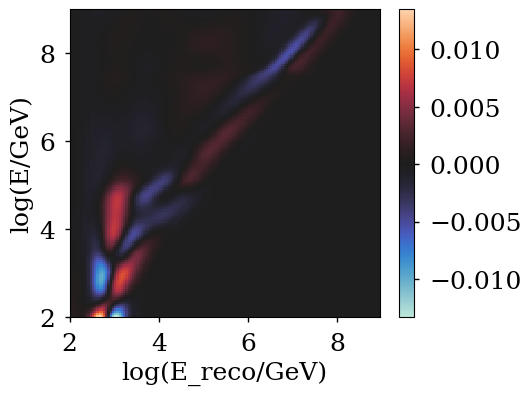

In [9]:
with open(join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"), "rb") as f:
    artificial_2D = pickle.load(f)

_ = plt.plot(artificial_2D.bin_mids[1], artificial_2D.histo.T)

artificial_2D.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")

plt.title("Artificial E-smearing")

(eres_up_mh - artificial_2D).T().plot(cmap="icefire")


## 1:1 reco reproduction

Text(0.5, 1.0, 'Artificial E-smearing 1:1')

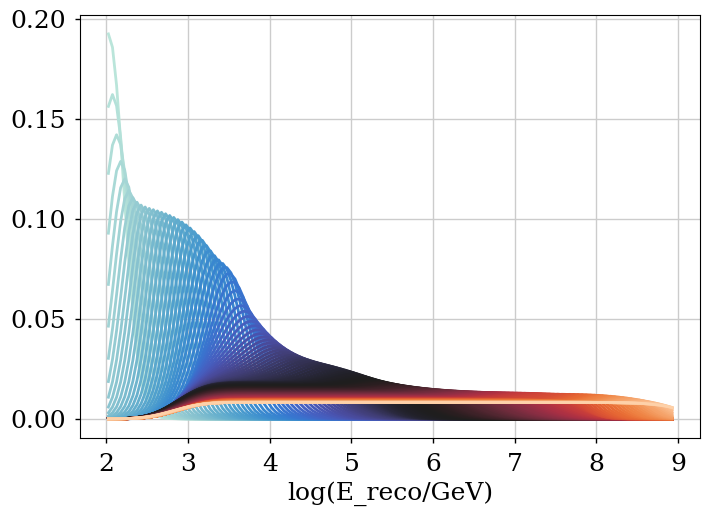

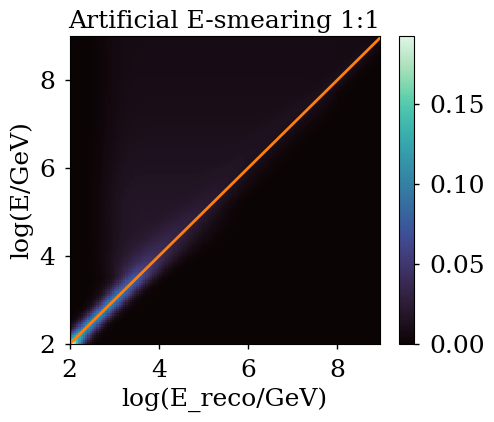

In [10]:
with open(join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"), "rb") as f:
    artificial_one2one = pickle.load(f)
_ = plt.plot(artificial_one2one.bin_mids[1], artificial_one2one.histo.T)
plt.xlabel(artificial_one2one.axis_names[1])

artificial_one2one.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")

plt.title("Artificial E-smearing 1:1")


## Improved artificial energy smearing

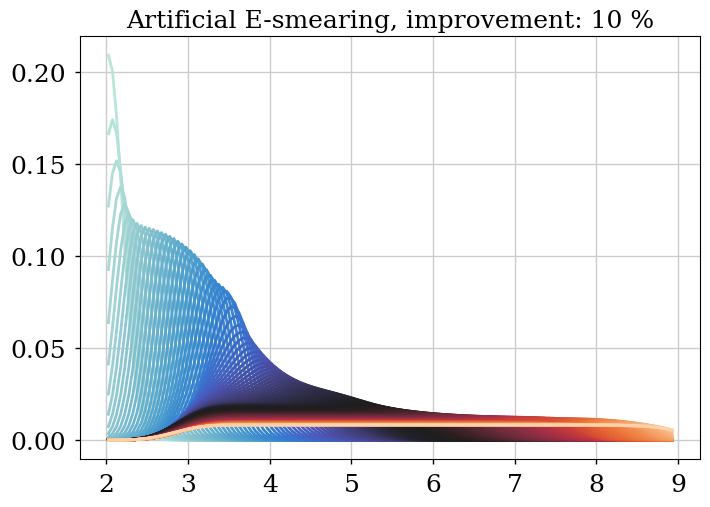

<Figure size 800x550 with 0 Axes>

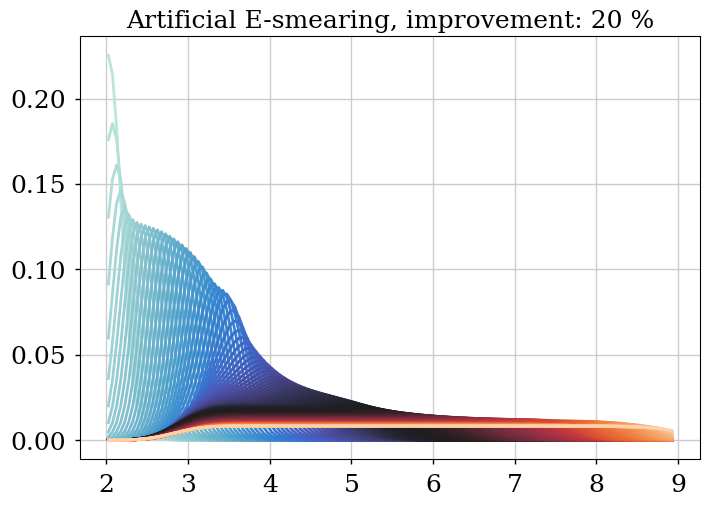

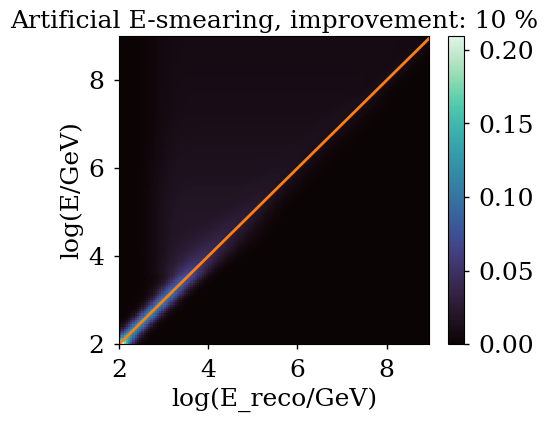

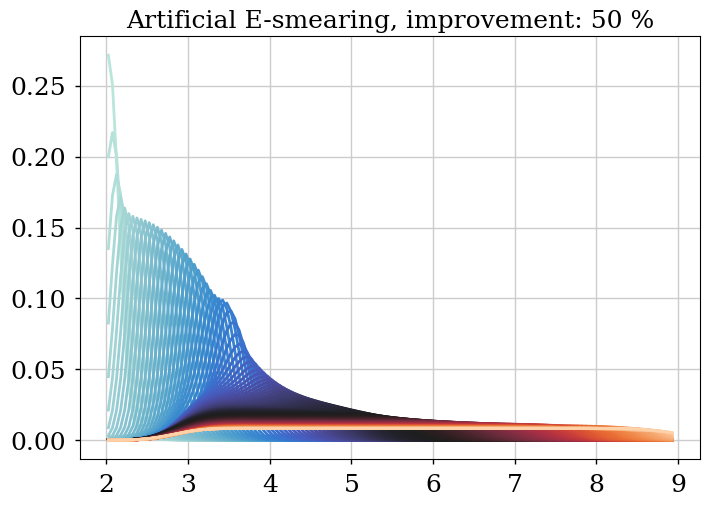

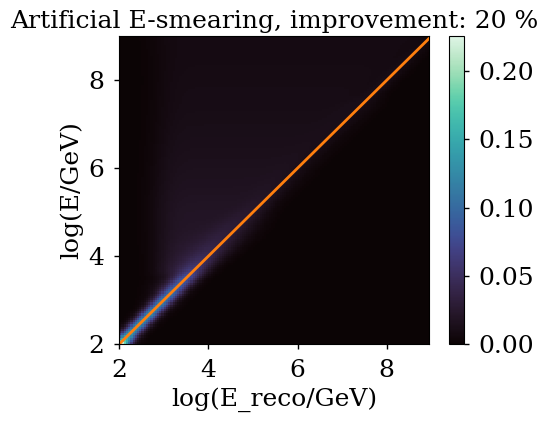

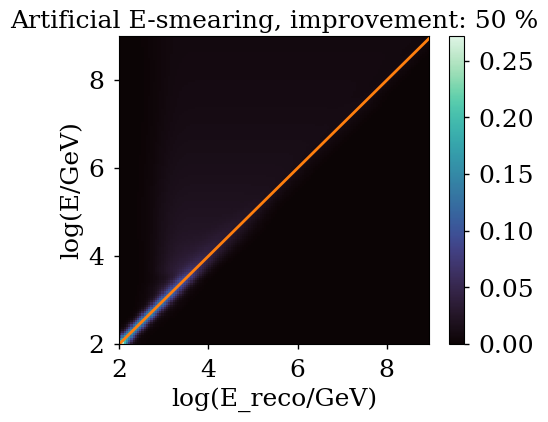

In [11]:
for ii, impro_factor in enumerate([0.1, 0.2, 0.5]):
    filename = join(
        LOCALPATH,
        f"improved_{impro_factor}_artificial_energy_smearing_GP_up.pckl",
    )
    with open(filename, "rb") as f:
        artificial_2D_impro = pickle.load(f)
    plt.figure(ii)
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    _ = plt.plot(artificial_2D_impro.bin_mids[1], artificial_2D_impro.histo.T)

    plt.figure(ii + 20)
    artificial_2D_impro.T().plot()
    plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")
    
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")


# UHE energy smearing
-- not yet updated -- see ../sandbox/energy_resolution_test.ipynb